# Tensorflow 2 Keras Model



Keras에서 모델을 만드는 방법은 크게 [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model)를 이용하는 방법과 [Functional API](https://www.tensorflow.org/guide/keras/functional)를 이용하는 방법이 있습니다.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Concatenate, Flatten, Add, MaxPooling2D, GlobalAveragePooling2D

2022-08-07 15:37:23.141193: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Sequantial API

`Sequential` API는 각 레이어에 **정확히 하나의 입력 텐서와 하나의 출력 텐서**가 있는 **일반 레이어 스택**에 적합합니다.  
다음과 같이 모델을 만들 수 있습니다.

In [2]:
# list에 layer를 차례대로 넣습니다
model_seq1 = tf.keras.Sequential([
    Dense(100),
    Dense(200),
    Dense(300)
])

2022-08-07 15:37:27.448354: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-08-07 15:37:27.538464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-08-07 15:37:27.539927: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:1d:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-08-07 15:37:27.541613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:3d:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 8

다음과 같이 `add` 메서드를 이용해서 하나씩 레이어를 추가할 수 있습니다.

In [3]:
model_seq2 = tf.keras.Sequential()
model_seq2.add(Dense(100))
model_seq2.add(Dense(200))
model_seq2.add(Dense(300))

## Functional API
`Functional` API는 `Sequential`API보다 더 유연한 모델을 만들 수 있습니다. 위에서 만든 모델을 `Functional` API를 이용해서 만들어 보겠습니다.

In [4]:
inputs = Input(shape=(784)) #먼저 Input layer를 만듭니다. shape는 임의로 설정했습니다.
x = Dense(100)(inputs) # 각 layer의 output을 다음 layer의 input으로 넣어주면 됩니다.
x = Dense(200)(x)
outputs = Dense(300)(x)

model_func = tf.keras.Model(inputs=inputs, outputs=outputs) #마지막엔 tf.keras.Model을 이용합니다.

이번에는 다양한 구조의 모델을 `Functional` API를 이용해서 만들어 보겠습니다.

### Residual connection (Skip connection)

residual connection은 특정 layer의 output이 이후의 몇개 layer를 통과하지 않고 우회하는 connection입니다.
아래와 같은 구조의 모델을 만들어 보겠습니다. 각 Dense layer의 node 갯수는 100개이고, ReLU Activation을 사용합니다.
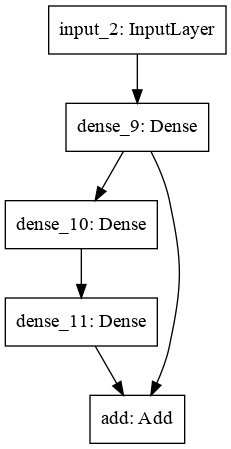

In [21]:
inputs = Input(shape=(28, 28, 1))
#code
x = Dense(100, activation='relu')(inputs)
shortcut = x
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
outputs = Add()([x, shortcut])

model_res = tf.keras.Model(inputs=inputs, outputs= outputs)

In [22]:
!pip install pydot pydotplus graphviz #then kernel restart

`tf.keras.utils.plot_model`을 이용하면 모델 시각화가 가능합니다. 위에 있는 그림과 동일하게 출력되는지 확인해 봅시다.

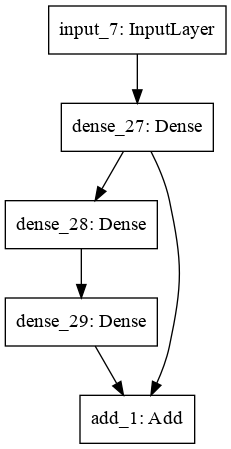

In [23]:
# This may not work if graphviz is not installed.. you need to install by apt-get install
tf.keras.utils.plot_model(model_res, to_file='model_res.png')

### Multiple inputs / outputs (Inception structure)

특정 layer의 output을 여러 layer가 동시에 input으로 이용하는 경우, 여러 layer의 output이 하나의 layer의 input으로 들어가는 경우도 가능합니다.

아래 셀의 출력에 표시된 그림과 같은 구조의 모델을 만들어 보겠습니다. 각 Dense layer의 Node 갯수는 100개이고 ReLU activation을 사용합니다. 단, 마지막 Dense layer는 Softmax activation을 사용합니다.
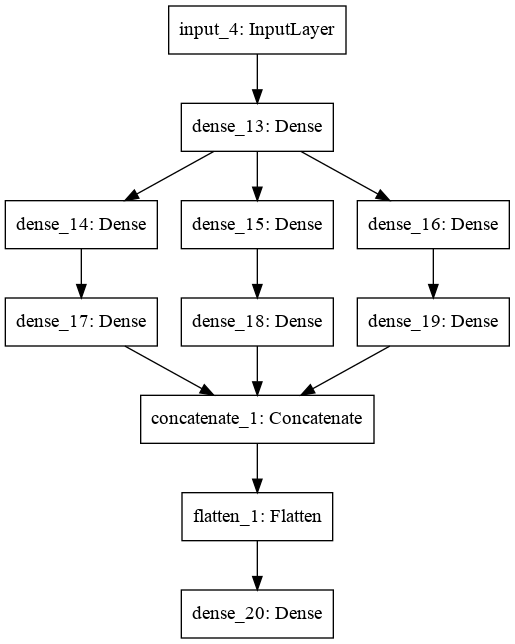

In [14]:
inputs = Input(shape=(28, 28, 1))
#########code
x1 = Dense(100, activation='relu')(inputs)

x_1_1 = Dense(100, activation='relu')(x1)
x_2_1 = Dense(100, activation='relu')(x1)
x_3_1 = Dense(100, activation='relu')(x1)

x_1_2 = Dense(100, activation='relu')(x_1_1)
x_2_2 = Dense(100, activation='relu')(x_2_1)
x_3_2 = Dense(100, activation='relu')(x_3_1)

x = Concatenate(axis=-1)([x_1_2, x_2_2, x_3_2])

x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x)
########
model_multi = tf.keras.Model(inputs=inputs, outputs=outputs) 

시각화를 통해 동일한 구조로 출력되는지 확인해 봅시다.

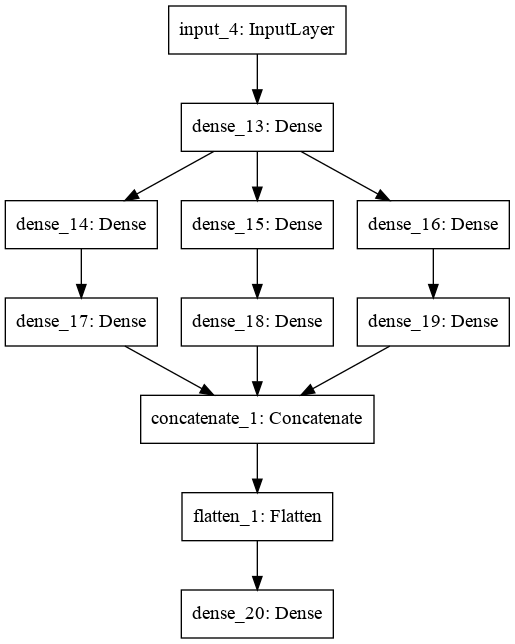

In [17]:
tf.keras.utils.plot_model(model_multi, to_file='model_multi.png')

### Sharing layer

아래의 그림처럼 두 개의 모델이 특정 layer를 공유할 수도 있습니다.
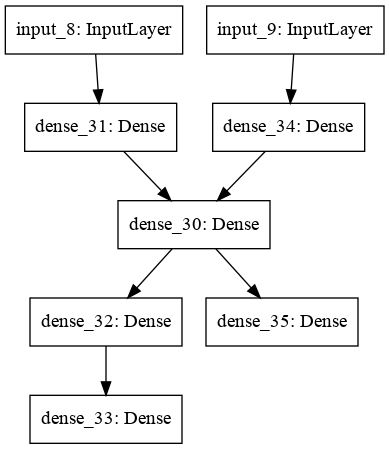

In [24]:
# 공유할 layer
layer_share = Dense(100, activation='relu')

# Model 1
inputs1 = Input(shape=(28, 28, 1))
#code
x1 = Dense(100, activation='relu')(inputs1)
x1 = layer_share(x1)
x1 = Dense(100, activation='relu')(x1)

outputs1 = Dense(10, activation='softmax')(x1)
model1 = tf.keras.Model(inputs=inputs1, outputs=outputs1)


# Model 2
inputs2 = Input(shape=(32, 32, 3))
#code
x2 = Dense(100, activation='relu')(inputs2)
x2 = layer_share(x2)

outputs2 = Dense(10, activation='softmax')(x2)
model2 = tf.keras.Model(inputs=inputs2, outputs=outputs2)

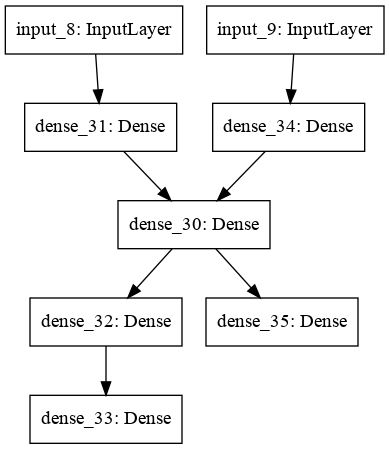

In [25]:
model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=[outputs1, outputs2])
tf.keras.utils.plot_model(model, to_file='model_share.png')

이와 같이 `Functional` API를 이용하면 모델을 유연하게 만들 수 있습니다.

# 과제: 간단한 ResNet 구현

다음은 ResNet을 MLP layer만을 이용하여 조금 더 간단하게 만든 ResNet11 모델의 구조이다.(https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf) `ResBlock`함수를 작성한 다음 `ResNet11`함수를 이용하여 ResNet-11를 구현해보자.
조건1: 1번째 ResBlock의 node는 100개, 2,3번째 ResBlock의 node는 200개를 사용한다.
조건2: 마지막 Layer의 node 수는 10개이다.
조건3: Activation은 모두 ReLU를 사용한다. 단, 마지막 layer에서는 Softmax activation을 사용한다. 
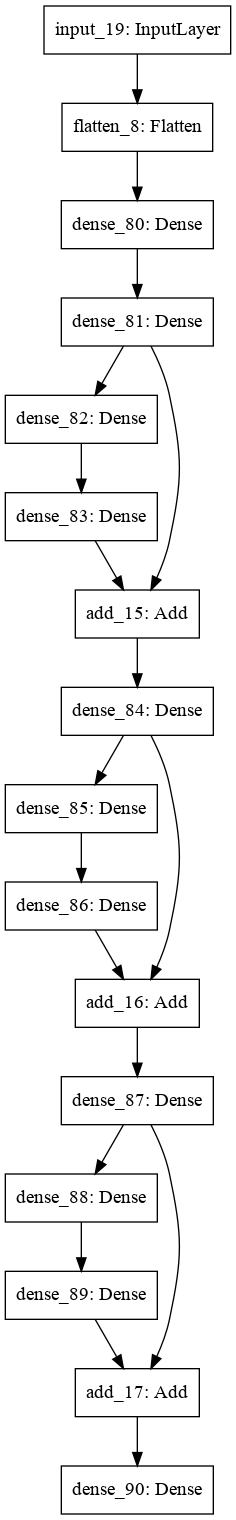


In [41]:
def ResBlock(x, nodes):
    ##################
    # Your code here
    ##################    

    ##################
    
    return x    

In [44]:
def ResNet11():
    inputs = Input(shape=(224, 224, 3))    
    x = Flatten()(inputs)
    x = Dense(100)(x)
    ##################
    # Your code here
    ##################

    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [49]:
resnet11 = ResNet11()

In [ ]:
tf.keras.utils.plot_model(resnet11, to_file='resnet11.png')